In [11]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statistics import mean
from datetime import date
import file

In [12]:
# Define the ticker symbol
tickerSymbol = 'SMH'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
history = tickerData.history(interval='1wk', start='2022-1-1', end=date.today())

In [13]:
CL = history['Low'].shift(-1) / history['Close'] - 1
print(f'{tickerSymbol} Close to next Low median {CL.median():.2%}')

SMH Close to next Low median -2.69%


In [14]:
max_weeks = 50

gap = (5/205)*100
option_prices = {
    1: [210/2.21, 220/2.93, 220/2.36], # very negative
    2: [210/3.72, 220/4.25, 220/3.92],
    3: [210/4.7, 220/5.43, 220/6.05],
    4: [210/5.6, 220/7.45, 220/6.72],
    5: [210/7.5, 220/7.9, 220/7.55],
    6: [210/7.85, 220/8.9, 220/8.55],
    7: [220/9.23],
    8: [220/10.27],
    9: [210/9.82],
    11: [220/11.85],
    12: [220/12.82],
    13: [210/12.05],
    15: [220/14.27],
    16: [220/15.12],
    17: [210/14.35],
    20: [220/17.02],
    21: [220/17.4],
    22: [210/16.75],
    26: [240/24.05],
    28: [220/21.72],
    29: [220/21.52],
    30: [210/20.37],
    33: [220/23.87],
    34: [220/24.25],
    35: [210/22.45],
    37: [220/24.32],
    38: [220/25.05],
    39: [210/23.17]
}
print('option leverages:')
for w in sorted(option_prices.keys()):
    print(f'\t{w:2}w', *[f'{x:4.1f}' for x in option_prices[w]])

option_leverage = {w:mean(option_prices[w]) for w in option_prices}

# normalize values so longer expirations have lower leverage
option_leverage = {k: v for k, v in zip(sorted(option_leverage.keys()), sorted(option_leverage.values(), reverse=True))}

print('mean option leverage, break even:')
for w in sorted(option_leverage.keys()):
    print(f'\t{w:2}w {option_leverage[w]:4.1f} {gap + 100/option_leverage[w]:4.1f}%')
print(f'option gap: {gap:.2f}%')

file.save_option_leverage(tickerSymbol, option_leverage)

option leverages:
	 1w 95.0 75.1 93.2
	 2w 56.5 51.8 56.1
	 3w 44.7 40.5 36.4
	 4w 37.5 29.5 32.7
	 5w 28.0 27.8 29.1
	 6w 26.8 24.7 25.7
	 7w 23.8
	 8w 21.4
	 9w 21.4
	11w 18.6
	12w 17.2
	13w 17.4
	15w 15.4
	16w 14.6
	17w 14.6
	20w 12.9
	21w 12.6
	22w 12.5
	26w 10.0
	28w 10.1
	29w 10.2
	30w 10.3
	33w  9.2
	34w  9.1
	35w  9.4
	37w  9.0
	38w  8.8
	39w  9.1
mean option leverage, break even:
	 1w 87.8  3.6%
	 2w 54.8  4.3%
	 3w 40.5  4.9%
	 4w 33.3  5.4%
	 5w 28.3  6.0%
	 6w 25.7  6.3%
	 7w 23.8  6.6%
	 8w 21.4  7.1%
	 9w 21.4  7.1%
	11w 18.6  7.8%
	12w 17.4  8.2%
	13w 17.2  8.3%
	15w 15.4  8.9%
	16w 14.6  9.3%
	17w 14.6  9.3%
	20w 12.9 10.2%
	21w 12.6 10.3%
	22w 12.5 10.4%
	26w 10.3 12.1%
	28w 10.2 12.2%
	29w 10.1 12.3%
	30w 10.0 12.5%
	33w  9.4 13.1%
	34w  9.2 13.3%
	35w  9.1 13.5%
	37w  9.1 13.5%
	38w  9.0 13.5%
	39w  8.8 13.8%
option gap: 2.44%


In [15]:
stock_change = [None]
option_performance = []
for weeks in range(1, max_weeks):
    stock_changes = history['Close'].pct_change(periods=weeks) * 100
    stock_change.append(stock_changes.median()  * 52 / weeks) # annualized

    if weeks in option_leverage:
        lvr = option_leverage[weeks]
        option_profits = ((stock_changes[weeks:] - gap) * lvr - 100).clip(lower=-100)
        mean_profit = option_profits.mean() #* 52 / weeks # annualized
        positive_percent = (option_profits > 0).mean() * 100
        option_performance.append([weeks, mean_profit, positive_percent])
        history[f'Option {weeks}w'] = option_profits # ? * 52 / weeks # annualized

In [16]:
print('Option performance (weeks, profit, positive):')
for p in option_performance:
    print(f'\t{p[0]:2}w {p[1]:4.0f}% {p[2]:3.0f}%')

Option performance (weeks, profit, positive):
	 1w   -6%  26%
	 2w    7%  31%
	 3w   16%  34%
	 4w   17%  35%
	 5w   22%  38%
	 6w   29%  38%
	 7w   33%  41%
	 8w   32%  42%
	 9w   40%  44%
	11w   42%  45%
	12w   46%  46%
	13w   55%  49%
	15w   61%  53%
	16w   63%  53%
	17w   73%  52%
	20w   87%  56%
	21w   95%  58%
	22w  104%  58%
	26w  102%  59%
	28w  120%  68%
	29w  128%  68%
	30w  135%  68%
	33w  148%  74%
	34w  154%  72%
	35w  159%  73%
	37w  179%  72%
	38w  189%  74%
	39w  190%  76%


In [17]:
from file import save_file

save_file(tickerSymbol, option_performance)

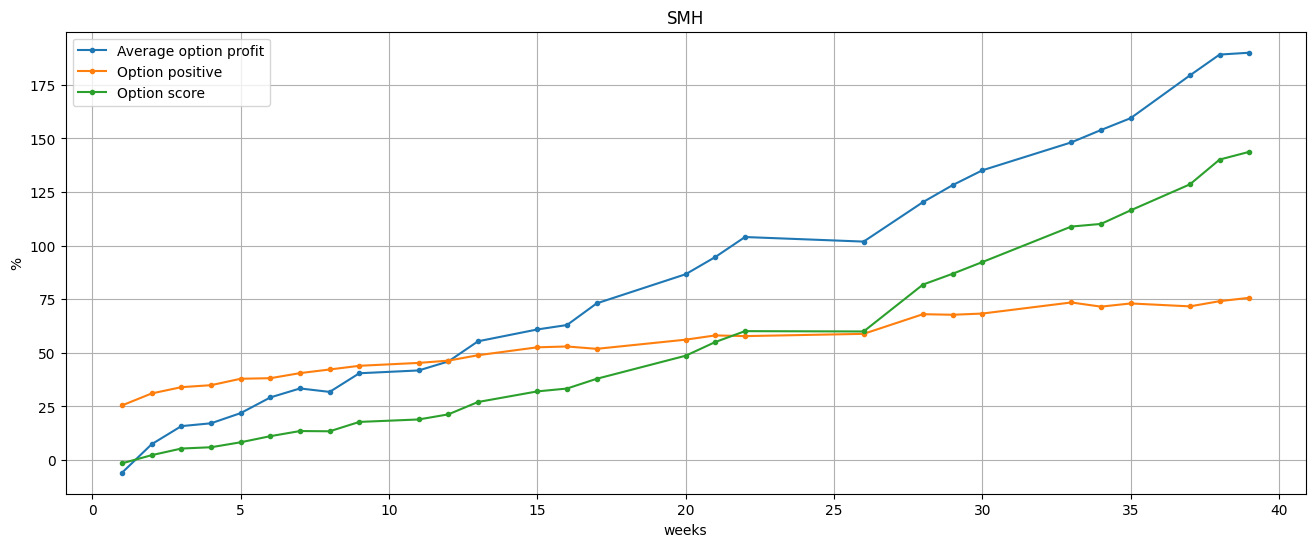

In [18]:
plt.figure(figsize=(16,6))
option_weeks = [p[0] for p in option_performance]
option_profit = [p[1] for p in option_performance]
option_positive = [p[2] for p in option_performance]
option_score = [x * y / 100 for x, y in zip(option_profit, option_positive)]
plt.plot(option_weeks, option_profit, label='Average option profit', marker='.')
plt.plot(option_weeks, option_positive, label='Option positive', marker='.')
plt.plot(option_weeks, option_score, label='Option score', marker='.')
plt.legend(loc='upper left')
plt.title(tickerSymbol)
plt.xlabel('weeks')
plt.ylabel('%')
plt.grid()
plt.show()

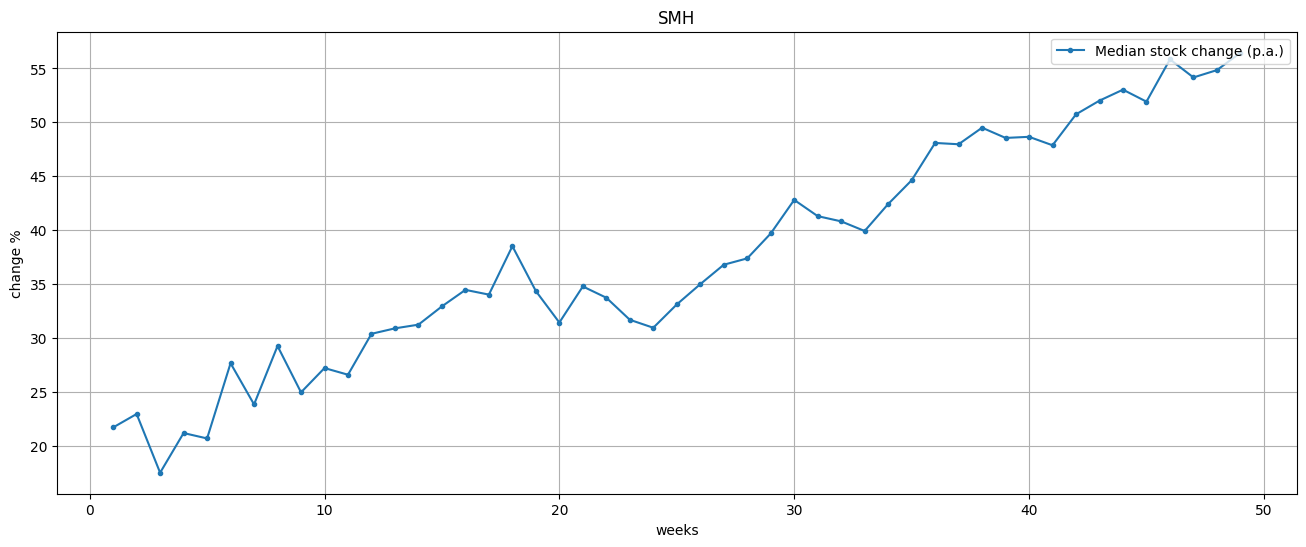

In [19]:
opt = [c * option_leverage[w] - 100 * 52 / w if w in option_leverage else None for w, c in enumerate(stock_change)]

plt.figure(figsize=(16,6))
plt.plot(stock_change, label='Median stock change (p.a.)', marker='.')
# plt.plot(opt, label='Median option gain (p.a.)', marker='.')
plt.legend(loc='upper right')
plt.title(tickerSymbol)
plt.xlabel('weeks')
plt.ylabel('change %')
plt.grid()
plt.show()


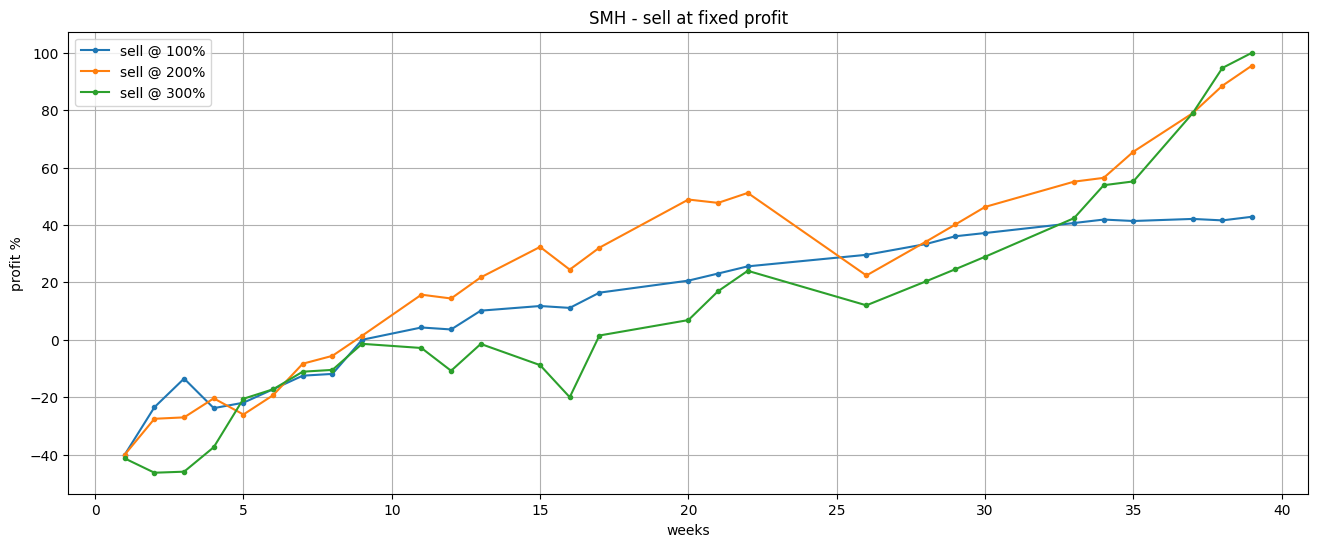

In [20]:
plt.figure(figsize=(16,6))

for percent in [100,200,300]:
    data = {}
    for weeks in option_leverage:
        lvr = option_leverage[weeks]
        window_max = history['High'].rolling(window=pd.api.indexers.FixedForwardWindowIndexer(window_size=weeks)).max()
        wmax = (((window_max / history['Open'] - 1) * 100 - gap) * lvr - 100).clip(lower=-100)
        wmax = wmax.dropna()
        q = (wmax >= percent).mean()
        data[weeks] = q * (percent + 100) - 100

    plt.plot(*zip(*sorted(data.items())), label=f'sell @ {percent}%', marker='.')

plt.legend(loc='best')
plt.title(f'{tickerSymbol} - sell at fixed profit')
plt.xlabel('weeks')
plt.ylabel('profit %')
plt.grid()
plt.show()